Preprocessing 

In [4]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
from shapely.geometry import Point
import statsmodels
import prophet


# File paths for each city
file_paths = {
    "CityA": "D:/lingyi/Documents/4032 data/4032-data/task1_dataset_kotae.csv",
    "CityB": "D:/lingyi/Documents/4032 data/4032-data/hiroshima_challengedata.csv",
    "CityC": "D:/lingyi/Documents/4032 data/4032-data/sapporo_challengedata.csv",
    "CityD": "D:/lingyi/Documents/4032 data/4032-data/kumamoto_challengedata.csv",
}

# POI data
poi_files = {
    "CityA": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityA.csv",
    "CityB": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityB.csv",
    "CityC": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityC.csv",
    "CityD": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityD.csv",
}
poi_categories_file = "D:/lingyi/Documents/4032 data/4032-data/POI_datacategories.csv"

# Define function to read and process POI data
def read_poi_data(file_path, categories_file):
    poi_data = pd.read_csv(file_path)
    poi_categories = pd.read_csv(categories_file, header=None, names=["category"])
    poi_data["category_name"] = poi_data["category"].apply(
        lambda x: poi_categories.iloc[x - 1]["category"] if 0 < x <= len(poi_categories) else "Unknown"
    )
    poi_data["geometry"] = [Point(xy) for xy in zip(poi_data["x"], poi_data["y"])]
    poi_gdf = gpd.GeoDataFrame(poi_data, geometry="geometry", crs="EPSG:3857")
    return poi_gdf

# Read POI data for all cities
poi_gdfs = {city: read_poi_data(poi_path, poi_categories_file) for city, poi_path in poi_files.items()}

# Reference date
reference_date = pd.to_datetime("2023-01-01")


Aggregating POI Visits

In [5]:
def process_city_in_chunks(file_path, poi_gdf, reference_date, chunk_size=100000, max_days=7):
    poi_gdf['grid_id'] = list(zip(poi_gdf['x'], poi_gdf['y']))  # Add 'grid_id' to POI data
    aggregated_results = []

    for chunk_idx, chunk in enumerate(
        pd.read_csv(file_path, usecols=['uid', 'd', 't', 'x', 'y'], chunksize=chunk_size)
    ):
        print(f"Processing chunk {chunk_idx + 1}")

        # Restrict to the first `max_days` (e.g., 7 days) and create a deep copy
        chunk = chunk[chunk['d'] < max_days].copy()
        if chunk.empty:
            print(f"Chunk {chunk_idx + 1} has no data for the first {max_days} days. Skipping.")
            continue

        # Preprocess the chunk
        chunk['x'] = chunk['x'].replace(-999, pd.NA)
        chunk['y'] = chunk['y'].replace(-999, pd.NA)
        chunk.dropna(subset=['x', 'y'], inplace=True)

        chunk['tracked_at'] = (
            reference_date +
            chunk['d'].apply(lambda x: timedelta(days=x)) +
            chunk['t'].apply(lambda x: timedelta(minutes=x * 30))
        )

        chunk['grid_id'] = list(zip(chunk['x'], chunk['y']))  # Create grid_id

        # Merge with POI data on 'grid_id'
        merged = chunk.merge(poi_gdf[['grid_id', 'category_name']], on='grid_id', how='inner')

        # Aggregate by category and date
        aggregated = merged.groupby(['category_name', merged['tracked_at'].dt.date])['uid'].nunique()
        aggregated_results.append(aggregated)

    # Combine results from all chunks
    return pd.concat(aggregated_results, axis=0)



# Process all cities
poi_visits_city = {
    city: process_city_in_chunks(file_paths[city], poi_gdfs[city], reference_date, max_days=21)
    for city in file_paths
}



Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18
Processing chunk 19
Processing chunk 20
Processing chunk 21
Processing chunk 22
Processing chunk 23
Processing chunk 24
Processing chunk 25
Processing chunk 26
Processing chunk 27
Processing chunk 28
Processing chunk 29
Processing chunk 30
Processing chunk 31
Processing chunk 32
Processing chunk 33
Processing chunk 34
Processing chunk 35
Processing chunk 36
Processing chunk 37
Processing chunk 38
Processing chunk 39
Processing chunk 40
Processing chunk 41
Processing chunk 42
Processing chunk 43
Processing chunk 44
Processing chunk 45
Processing chunk 46
Processing chunk 47
Processing chunk 48
Processing chunk 49
Processing chunk 50
Processin

Temporal Aggregation

In [6]:
def aggregate_weekly(poi_visits):
    # Reset index to make 'tracked_at' (date) a column
    poi_visits = poi_visits.reset_index()

    # Ensure the 'tracked_at' column is datetime-compatible
    poi_visits['tracked_at'] = pd.to_datetime(poi_visits['tracked_at'])

    # Aggregate by week
    poi_visits = poi_visits.groupby(['category_name', pd.Grouper(key='tracked_at', freq='W')]).sum()

    # Reset index to make 'category_name' a column
    poi_visits = poi_visits.reset_index()

    # Pivot to create a DataFrame with categories as columns
    pivoted = poi_visits.pivot(index='tracked_at', columns='category_name', values='uid')

    return pivoted


weekly_trends_city = {city: aggregate_weekly(poi_visits) for city, poi_visits in poi_visits_city.items()}




In [7]:
for city, trends in weekly_trends_city.items():
    print(f"\nCity: {city}")
    print(trends.head())  # Show the first few rows





City: CityA
category_name  Accountant Office  Amusement Restaurant  BBQ restaurant  \
tracked_at                                                               
2023-01-01                 86413                   210           63455   
2023-01-08                629073                  1839          473671   
2023-01-15                639517                  1978          482988   
2023-01-22                558323                  1745          425498   

category_name  Bakery    Bank     Bar  Beer Garden  Building Material    Café  \
tracked_at                                                                      
2023-01-01      62316   85811   73765         5532              88240   84738   
2023-01-08     457499  625394  544467        50529             640278  616985   
2023-01-15     466292  635892  554143        51546             650659  627456   
2023-01-22     409071  555029  486814        48917             567150  547739   

category_name  Casino  ...  Sweets   Swimming Pool  Tea

Analyzing Temporal Patterns 

Approach 1: Visualization:
Plot time series for each POI category to observe patterns

Approach 2: Decomposition:
Decompose the time series into trend, seasonality, and residuals using STL (Seasonal-Trend Decomposition):

Identify Top POI Categories by Popularity

In [8]:
# Total visitors by category for each city
for city, trends in weekly_trends_city.items():
    print(f"\nCity: {city}")
    total_visitors = trends.sum(axis=0).sort_values(ascending=False)  # Sum over weeks
    print(total_visitors.head(10))  # Top 10 categoriesN



City: CityA
category_name
Heavy Industry       1956896
Building Material    1946327
Home Appliances      1945011
Hair Salon           1939932
Laundry              1926103
Real Estate          1923443
Transit Station      1917391
Accountant Office    1913326
Driving School       1911271
Bank                 1902126
dtype: int64

City: CityB
category_name
Transit Station      461062
Heavy Industry       459954
Building Material    458960
Home Appliances      456593
Hair Salon           455544
Laundry              450081
Accountant Office    449958
Community Center     448299
Church               448051
Bank                 447294
dtype: int64

City: CityC
category_name
Transit Station      377244
Park                 375014
Building Material    373544
Home Appliances      371689
Hair Salon           371235
Real Estate          370344
Heavy Industry       369834
Accountant Office    369538
Laundry              369400
Elderly Care Home    368997
dtype: int64

City: CityD
category_name
Hea

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data within each city
normalized_trends_city = {}
for city, trends in weekly_trends_city.items():
    scaler = MinMaxScaler()
    normalized = pd.DataFrame(
        scaler.fit_transform(trends),
        index=trends.index,
        columns=trends.columns
    )
    normalized_trends_city[city] = normalized

# Check normalized data for one city
for city, trends in normalized_trends_city.items():
    print(f"\nNormalized Weekly Trends for {city}:")
    print(trends.head())



Normalized Weekly Trends for CityA:
category_name  Accountant Office  Amusement Restaurant  BBQ restaurant  \
tracked_at                                                               
2023-01-01              0.000000              0.000000        0.000000   
2023-01-08              0.981117              0.921380        0.977792   
2023-01-15              1.000000              1.000000        1.000000   
2023-01-22              0.853203              0.868213        0.862967   

category_name    Bakery      Bank       Bar  Beer Garden  Building Material  \
tracked_at                                                                    
2023-01-01     0.000000  0.000000  0.000000     0.000000           0.000000   
2023-01-08     0.978234  0.980916  0.979858     0.977898           0.981542   
2023-01-15     1.000000  1.000000  1.000000     1.000000           1.000000   
2023-01-22     0.858355  0.852998  0.859842     0.942865           0.851518   

category_name      Café    Casino  ...   Sw

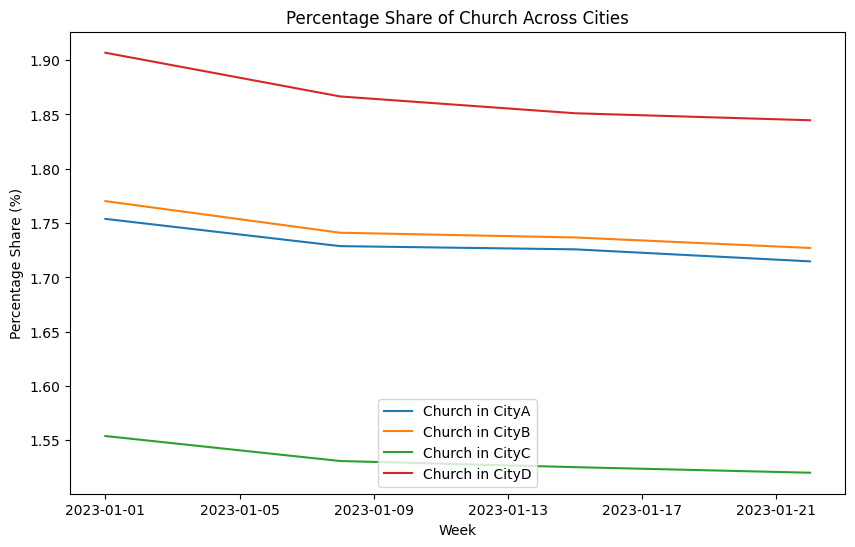

In [11]:
import matplotlib.pyplot as plt
# Calculate percentage share for each category within a city
percentage_share_city = {}
for city, trends in weekly_trends_city.items():
    percentage_share = trends.div(trends.sum(axis=1), axis=0) * 100
    percentage_share_city[city] = percentage_share

# Plot percentage share for a category across cities
category = 'Church'
plt.figure(figsize=(10, 6))
for city, trends in percentage_share_city.items():
    if category in trends.columns:
        plt.plot(trends.index, trends[category], label=f'{category} in {city}')
plt.title(f"Percentage Share of {category} Across Cities")
plt.xlabel("Week")
plt.ylabel("Percentage Share (%)")
plt.legend()
plt.show()


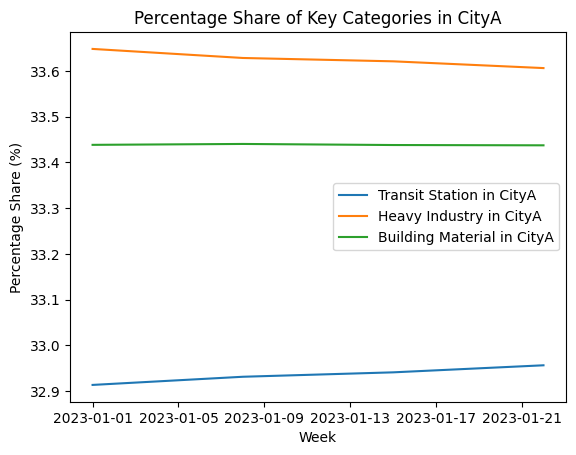

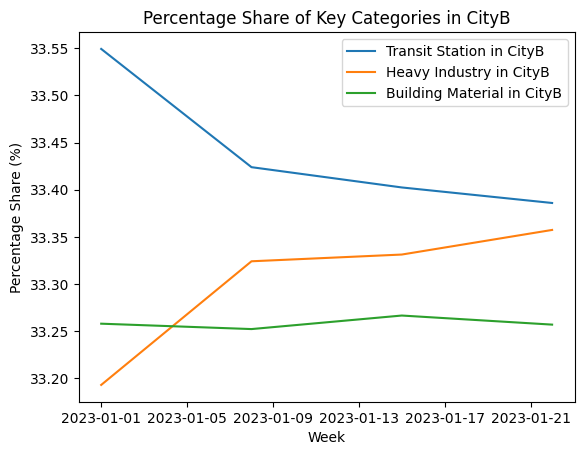

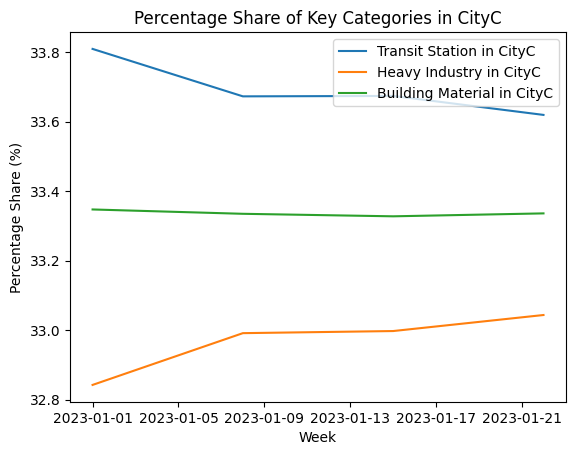

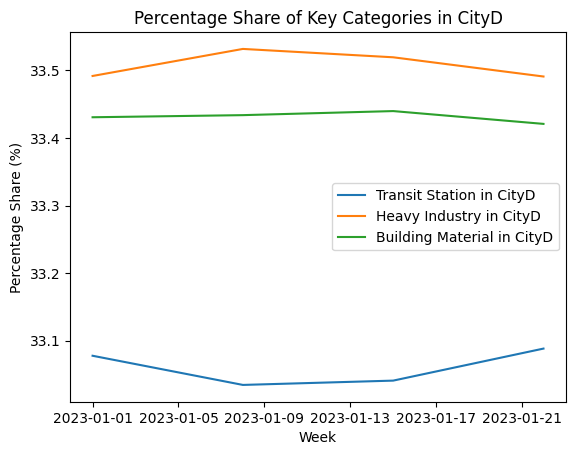

In [12]:
# Calculate percentage share for each city but focus on specific key categories
key_categories = ['Transit Station', 'Heavy Industry', 'Building Material']

for city, trends in weekly_trends_city.items():
    # Restrict to key categories for percentage share
    trends_key = trends[key_categories] if all(k in trends.columns for k in key_categories) else trends
    percentage_share = trends_key.div(trends_key.sum(axis=1), axis=0) * 100

    # Plot percentage share for each key category
    for category in key_categories:
        if category in percentage_share.columns:
            plt.plot(percentage_share.index, percentage_share[category], label=f'{category} in {city}')
    plt.title(f"Percentage Share of Key Categories in {city}")
    plt.xlabel("Week")
    plt.ylabel("Percentage Share (%)")
    plt.legend()
    plt.show()


Predicting Trends

In [13]:
for city, poi_visits in poi_visits_city.items():
    poi_visits_city[city] = poi_visits.reset_index()  # Reset multi-index to columns

In [14]:
# Inspect the structure of `poi_visits_city`
for city, poi_visits in poi_visits_city.items():
    print(f"\nCity: {city}")
    print(poi_visits.head())  # Check the first few rows



City: CityA
       category_name  tracked_at  uid
0  Accountant Office  2023-01-01   67
1  Accountant Office  2023-01-02   64
2  Accountant Office  2023-01-03   63
3  Accountant Office  2023-01-04   67
4  Accountant Office  2023-01-05   70

City: CityB
       category_name  tracked_at  uid
0  Accountant Office  2023-01-01   77
1  Accountant Office  2023-01-02   78
2  Accountant Office  2023-01-03   84
3  Accountant Office  2023-01-04   80
4  Accountant Office  2023-01-05   84

City: CityC
       category_name  tracked_at  uid
0  Accountant Office  2023-01-01   68
1  Accountant Office  2023-01-02   68
2  Accountant Office  2023-01-03   72
3  Accountant Office  2023-01-04   73
4  Accountant Office  2023-01-05   75

City: CityD
       category_name  tracked_at  uid
0  Accountant Office  2023-01-01   59
1  Accountant Office  2023-01-02   56
2  Accountant Office  2023-01-03   60
3  Accountant Office  2023-01-04   62
4  Accountant Office  2023-01-05   57


In [15]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def arima_forecast_poi_visits(poi_visits_city, categories_to_forecast):
    for city, poi_visits in poi_visits_city.items():
        print(f"ARIMA Forecasting for {city}")

        for category in categories_to_forecast:
            # Filter data for the specific category
            category_data = poi_visits[poi_visits['category_name'] == category]

            if category_data.empty:
                print(f"No data for {category} in {city}. Skipping.")
                continue

            # Sort by tracked_at
            category_data = category_data.sort_values(by='tracked_at')

            # Convert tracked_at to datetime and set as index
            category_data['tracked_at'] = pd.to_datetime(category_data['tracked_at'])

            # Handle duplicate timestamps by aggregating (e.g., summing 'uid')
            category_data = category_data.groupby('tracked_at', as_index=False)['uid'].sum()

            # Set the index to tracked_at
            category_data.set_index('tracked_at', inplace=True)

            # Ensure the index has a frequency (daily in this case)
            category_data = category_data.asfreq('D', fill_value=0)

            # Use the uid column as the time series
            data = category_data['uid']

            # Ensure sufficient data points
            if len(data.dropna()) < 10:  # At least 10 points are needed for ARIMA
                print(f"Not enough data points for {category} in {city}. Skipping.")
                continue

            # Fit ARIMA model
            model = ARIMA(data, order=(5, 1, 0))  # Adjust ARIMA order based on data
            fitted = model.fit()

            # Forecast the next 10 days
            forecast = fitted.forecast(steps=10)

            # Plot actual data and forecast
            plt.figure(figsize=(10, 6))
            plt.plot(data, label='Actual Data')
            plt.plot(forecast, label='Forecast', linestyle='--')
            plt.title(f"ARIMA Forecast for {category} in {city}")
            plt.xlabel("Date")
            plt.ylabel("Unique Visitors")
            plt.legend()
            plt.show()





ARIMA Forecasting for CityD


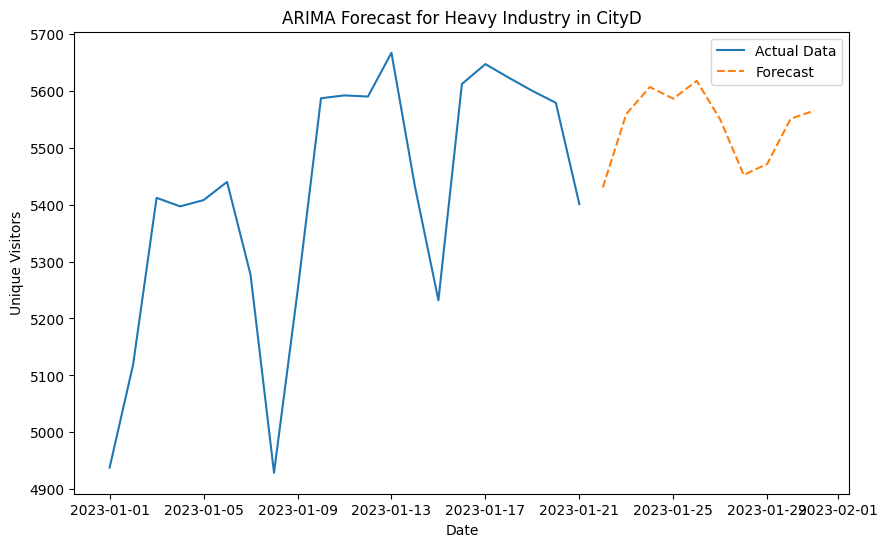

In [16]:
# Run ARIMA forecasting for only City D and 'Heavy Industry'
specific_city = 'CityD'
specific_category = ['Heavy Industry']

# Call the ARIMA forecasting function for the specific city and category
arima_forecast_poi_visits({specific_city: poi_visits_city[specific_city]}, specific_category)


In [17]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def prophet_forecast_poi_visits(poi_visits_city, categories_to_forecast, periods=30):
    for city, poi_visits in poi_visits_city.items():
        print(f"Prophet Forecasting for {city}")

        for category in categories_to_forecast:
            # Filter data for the specific category
            category_data = poi_visits[poi_visits['category_name'] == category]

            if category_data.empty:
                print(f"No data for {category} in {city}. Skipping.")
                continue

            # Prepare data for Prophet
            category_data = category_data.groupby('tracked_at', as_index=False)['uid'].sum()
            category_data['tracked_at'] = pd.to_datetime(category_data['tracked_at'])
            category_data.rename(columns={'tracked_at': 'ds', 'uid': 'y'}, inplace=True)

            # Initialize and fit Prophet model
            model = Prophet()
            model.fit(category_data)

            # Create future DataFrame and forecast
            future = model.make_future_dataframe(periods=periods, freq='D')
            forecast = model.predict(future)

            # Plot forecast
            fig = model.plot(forecast)
            plt.title(f"Prophet Forecast for {category} in {city}")
            plt.xlabel("Date")
            plt.ylabel("Unique Visitors")
            plt.show()

            # Plot trend and seasonality components
            fig2 = model.plot_components(forecast)
            plt.show()


17:03:44 - cmdstanpy - INFO - Chain [1] start processing


Prophet Forecasting for CityA


17:03:44 - cmdstanpy - INFO - Chain [1] done processing


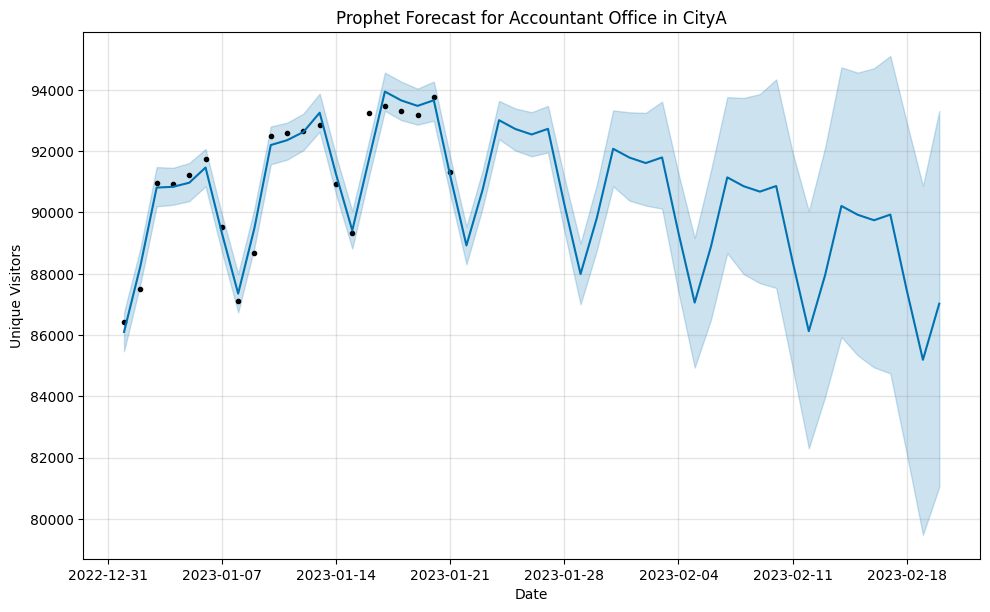

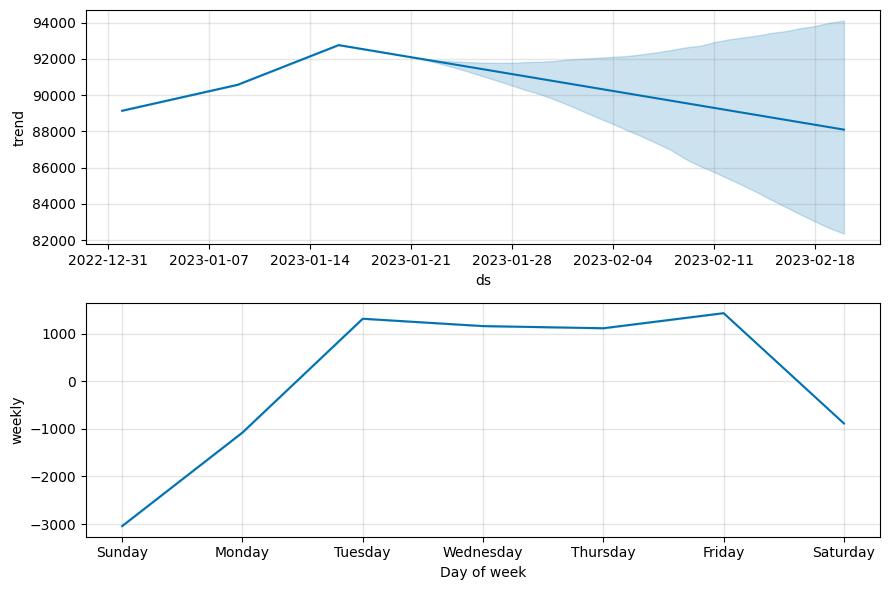

In [18]:
# Run Prophet forecasting for only City A and 'Heavy Industry'
specific_city = 'CityA'
specific_category = ['Accountant Office']

# Call the Prophet forecasting function for the specific city and category
prophet_forecast_poi_visits({specific_city: poi_visits_city[specific_city]}, specific_category, periods=30)
